#System Setup

In [12]:
!pip install klib sentencepiece transformers --quiet

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
import klib
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import optim
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import T5Tokenizer, MT5ForConditionalGeneration
from tqdm.notebook import tqdm as tqdm_notebook_
from scipy.signal import savgol_filter
import random
import copy
import os

In [14]:
# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:

# Navigate to folder
%cd /content/drive/MyDrive/lang-id

/content/drive/MyDrive/lang-id


# Data Preparation

In [16]:
# Read the dataset tsv file
df = pd.read_csv('xnli15.tsv', sep='\t')
print('Dataframe shape: ', df.shape)
df.head(5)

Dataframe shape:  (10000, 15)


,ar,bg,de,el,en,es,fr,hi,ru,sw,th,tr,ur,vi,zh
0,وقال، ماما، لقد عدت للمنزل.,"И той каза: Мамо, у дома съм.","und er hat gesagt, Mama ich bin daheim.","Και είπε, Μαμά, έφτασα στο σπίτι.","And he said, Mama, I'm home.","Y él dijo: Mamá, estoy en casa.","Et il a dit, maman, je suis à la maison.","और उसने कहा, माँ, मैं घर आया हूं।","И он сказал: Мама, я дома.","Naye akasema, Mama, niko nyumbani.","และเขาพูดว่า, ม่าม๊า ผมอยู่บ้าน","Ve Anne, evdeyim dedi.",اور اس نے کہا امّی، میں گھر آگیا ہوں۔,"Và anh ấy nói, Mẹ, con đã về nhà.",他说，妈妈，我回来了。
1,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,"Е, аз дори не мислех за това, но бях толкова р...","Nun, daran dachte ich nicht einmal, aber ich w...","Λοιπόν, δεν το σκέφτηκα καν, αλλά ήμουν τόσο α...","Well, I wasn't even thinking about that, but I...","Bien, ni estaba pensando en eso, pero estaba t...","Eh bien, je ne pensais même pas à cela, mais j...",हालांकि मैं इसके बारे में सोच भी नहीं रहा था ल...,"Ну, я даже не думал об этом, но я был так разо...","Naam, sikukuwa nafikiri juu ya hilo, lakini ni...","ดี, ฉันไม่ได้คิดอะไรเกี่ยวกับเรื่องนี้, แต่ฉัน...","Pekala, bunu hiç düşünmemiştim ancak kafam çok...",میں اس کے بارے میں نہیں سوچھ رہی تھی ، لیکن می...,"Vâng, tôi thậm chí không nghĩ về điều đó, nhưn...",嗯，我根本没想过，但是我很沮丧，最后我又和他说话了。
2,واعتقدت أن ذلك شرف لي ، ولا يزال ، ولايزال ، ك...,"И аз мислех, че това е привилегия, и тя все ощ...","„Und ich dachte, das wäre ein Privileg, und da...","Και σκέφτηκα ότι ήταν ένα προνόμιο, και είναι ...","And I thought that was a privilege, and it's s...","Y pensé que era un privilegio, y todavía es, t...","Et je pensais que c'était un privilège, et ça ...","और मैंने सोचा कि यह एक विशेषाधिकार था, और यह अ...","А я считал это привилегией, и всё-же, и всё-ж...","Nami nilifikiri kwamba ilikuwa ni fursa, na ba...",และฉันนึกว่านั้นเป็นสิทธิพิเศษและมันยังคงเป็น ...,"Ve bunun bir ayrıcalık olduğunu sanıyordum, ve...",اور میں نے سوچا کہ یہ ایک امتیاز تھا، اور یہ ا...,"Và tôi nghĩ đó là một đặc ân, và nó vẫn còn, n...",而我当初认为这是一个特权，我现在仍然这样想，我是唯一的922 Ex-O，也是我的AFFC空军...
3,أخبروني ،إيه، أنه سيتم استدعائي من قبل شاب في ...,"Казаха ми, че накрая ще ми се обади човек, за ...","Sie sagten mir, dass ich am Ende von einem Ker...","Μου είπαν ότι, θα έπρεπε να καλέσω έναν άντρα ...","They told me that, uh, that I would be called ...","Me dijeron que, esto... que un tipo me llamarí...","Ils m'ont dit qu'à la fin, on m'amènerait un h...",उन्होंने मुझसे कहा की अंत में एक व्यक्ति से मी...,"Они сказали, что меня вызовут , чтобы встретит...",Walinieleza ya kwamba mwishowe ningeitiwa jama...,พวกเขาบอกฉันว่าเขาจะเรียกคน ๆ หนึ่งเข้ามาในตอน...,Sonunda tanışmam için bir adam tarafından çağr...,انہوں نے مجھے بتایا تھا کے آخر میں مجھ سے ملنے...,"Họ nói với tôi rằng, ừ, rằng tôi sẽ được gọi b...",他们告诉我，呃，我最后会被叫到一个人那里去见面。
4,هناك الكثير تستطيع التحدث عنه وأنا سوف أتاجاو...,"Има толкова много, което може да се разкаже за...",Es gibt so viel was ich darüber erzählen könnt...,Υπάρχουν τόσα πολλά που θα μπορούσες να μιλήσε...,There's so much you could talk about on that I...,"Hay tanto que se puede decir sobre eso, que se...",Il y a tellement de choses dont vous pourriez ...,इतना है कि आप इसके बारे में बात कर सकते हैं कि...,"Об этом можно так много говорить, что я опущу ...",Kuna mengi ambayo unaweza kuzungumzia kuhusu h...,มันมีอีกมากที่คุณสามารถพูดคุยเกี่ยวกับสิ่งนั้น...,Bu konu hakkında söyleyebileceğin çok şey var ...,بہت اتنا ہے کہ آپ اس کے بارے میں بات کر سکتے ہ...,Có rất nhiều điều bạn có thể nói mà tôi sẽ chỉ...,你可以讲的太多了，我就不提了。


In [17]:
# Display the column headers represening each language

print(f'number of languages in the dataset = {len(df.columns)}')
print(df.columns)

number of languages in the dataset = 15
Index(['ar', 'bg', 'de', 'el', 'en', 'es', 'fr', 'hi', 'ru', 'sw', 'th', 'tr',
       'ur', 'vi', 'zh'],
      dtype='object')


In [18]:
# Using list comprehension for efficient data preparation
data_prep = [(row, col) for col in df.columns for row in df[col]]

# Creating the DataFrame directly from the prepared data
dataframe = pd.DataFrame(data_prep, columns=['input_text', 'target_text'])

# Displaying the DataFrame
display(dataframe)


,input_text,target_text
0,وقال، ماما، لقد عدت للمنزل.,ar
1,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,ar
2,واعتقدت أن ذلك شرف لي ، ولا يزال ، ولايزال ، ك...,ar
3,أخبروني ،إيه، أنه سيتم استدعائي من قبل شاب في ...,ar
4,هناك الكثير تستطيع التحدث عنه وأنا سوف أتاجاو...,ar
...,...,...
149995,戴维森不应该以骨头和烤饼听起来一样的方式说话。,zh
149996,"如果戴维森押韵饼和骨头的话, 那就更好了。",zh
149997,价值25美元的20万字小说价格合理。,zh
149998,"25美元的20万字的小说就是每美元4,000字。",zh


In [19]:
# Data cleaning
dataframe=klib.data_cleaning(dataframe)
dataframe=dataframe.drop_duplicates(subset='input_text', keep=False)
display(dataframe)

Shape of cleaned data: (149935, 2) - Remaining NAs: 0


Dropped rows: 65
     of which 65 duplicates. (Rows (first 150 shown): [6857, 7729, 9884, 12718, 13918, 15238, 16857, 23871, 24239, 33918, 46857, 52305, 55046, 58715, 59687, 61237, 62324, 63918, 65271, 72853, 73873, 75977, 78367, 85271, 92321, 95238, 98105, 103393, 103871, 109555, 116857, 116878, 119674, 121001, 121144, 121204, 121224, 121269, 121366, 121371, 121382, 121487, 121678, 121933, 121943, 121978, 122000, 122139, 122199, 122321, 122420, 122475, 124419, 125471, 125845, 125860, 128946, 130755, 132988, 133918, 137847, 143683, 145271, 145673, 146857])

Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 1.0 MB (-43.67%)



,input_text,target_text
0,وقال، ماما، لقد عدت للمنزل.,ar
1,حسنا ، لم أكن أفكر حتى حول ذلك ، لكن كنت محبطا...,ar
2,واعتقدت أن ذلك شرف لي ، ولا يزال ، ولايزال ، ك...,ar
3,أخبروني ،إيه، أنه سيتم استدعائي من قبل شاب في ...,ar
4,هناك الكثير تستطيع التحدث عنه وأنا سوف أتاجاو...,ar
...,...,...
149930,戴维森不应该以骨头和烤饼听起来一样的方式说话。,zh
149931,"如果戴维森押韵饼和骨头的话, 那就更好了。",zh
149932,价值25美元的20万字小说价格合理。,zh
149933,"25美元的20万字的小说就是每美元4,000字。",zh


In [20]:
# Adding prefix text '<idf.lang> ' to each entry in the 'input_text' column
# This prefix helps in providing context or specific instructions to the model
dataframe['input_text'] = dataframe['input_text'].apply(lambda x: '<idf.lang> ' + str(x))

# Displaying the updated DataFrame
display(dataframe)


<ipython-input-20-8dcb07f1607c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['input_text'] = dataframe['input_text'].apply(lambda x: '<idf.lang> ' + str(x))


,input_text,target_text
0,<idf.lang> وقال، ماما، لقد عدت للمنزل.,ar
1,<idf.lang> حسنا ، لم أكن أفكر حتى حول ذلك ، لك...,ar
2,<idf.lang> واعتقدت أن ذلك شرف لي ، ولا يزال ، ...,ar
3,<idf.lang> أخبروني ،إيه، أنه سيتم استدعائي من ...,ar
4,<idf.lang> هناك الكثير تستطيع التحدث عنه وأنا...,ar
...,...,...
149930,<idf.lang> 戴维森不应该以骨头和烤饼听起来一样的方式说话。,zh
149931,"<idf.lang> 如果戴维森押韵饼和骨头的话, 那就更好了。",zh
149932,<idf.lang> 价值25美元的20万字小说价格合理。,zh
149933,"<idf.lang> 25美元的20万字的小说就是每美元4,000字。",zh


In [21]:
# Splitting the dataset into train, validation, and test
train_val_df, test_df = train_test_split(dataframe, test_size=0.21, random_state=42)
train_df, eval_df = train_test_split(train_val_df, test_size=0.24, random_state=42)
print('Training dataset shape: ', train_df.shape)
print('Validation dataset shape: ', eval_df.shape)
print('Testing dataset shape: ', test_df.shape)


Training dataset shape:  (89959, 2)
Validation dataset shape:  (28409, 2)
Testing dataset shape:  (31466, 2)


#Load the model

In [22]:
model_repo = 'google/mt5-small'
model_path = '/content/drive/MyDrive/lang-id/fine-tuned_mt5/'
if not os.path.exists(model_path):
  os.mkdir(model_path)

In [23]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [24]:
# Loading the tokenizer and the model from huggingface hub
tokenizer = AutoTokenizer.from_pretrained(model_repo)
model = MT5ForConditionalGeneration.from_pretrained(model_repo)
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [25]:
print(f'len of the tokenizer vocabulary = {len(tokenizer.vocab)}')
print(f'model.config.max_length = {model.config.max_length}')

len of the tokenizer vocabulary = 250100
model.config.max_length = 20


In [26]:
# Adding the prefix <idf.lang> as a special token
LANG_TOKEN_MAPPING = {
    'identify language': '<idf.lang>'
}
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
print(f'Special Token : {special_tokens_dict}')

print(f"adding special tokens to the tokenizer vocab")
tokenizer.add_special_tokens(special_tokens_dict)

Special Token : {'additional_special_tokens': ['<idf.lang>']}
adding special tokens to the tokenizer vocab


1

In [27]:
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>', '<idf.lang>']

In [28]:
model.config.vocab_size

250112

In [29]:
model.resize_token_embeddings(len(tokenizer))

Embedding(250101, 512)

# Encoding the data

In [30]:
# Setting input sequence length
max_inp_seq_len = 40
max_tar_seq_len = 3

In [31]:
def encode_str(text, tokenizer, seq_len):
  """ Tokenize, pad to max length and encode to ids
      Returns tensor with token ids """
  input_ids = tokenizer.encode(
      text=text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

In [32]:
# Testing the encode_str function

print(train_df['input_text'].iloc[0])
t1 = encode_str(train_df['input_text'].iloc[0],tokenizer,max_inp_seq_len)
print(t1)
tokens = tokenizer.convert_ids_to_tokens(t1)
print(tokens)

<idf.lang> सांप नदी सांपों  से भरा है।
tensor([250100,   4736,  27185,    259,    863,   7553,   4736,  27185,   1396,
          1162,   2573,   3409,    830,    378,      1,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0])
['<idf.lang>', '▁सा', 'ंप', '▁', 'न', 'दी', '▁सा', 'ंप', 'ों', '▁से', '▁भ', 'रा', '▁है', '।', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [33]:
# encode a row
def encode_row(row, tokenizer, seq_inp_len, seq_tar_len):
  input_text = row['input_text']
  target_text = row['target_text']

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_str(
      input_text, tokenizer, seq_inp_len)

  target_token_ids = encode_str(
      target_text, tokenizer, seq_tar_len)

  return input_token_ids, target_token_ids

In [34]:
# encode a single batch
def encode_batch(batch, tokenizer):
  inputs = []
  targets = []
  for index, row in batch.iterrows():
    formatted_data = encode_row(
        row, tokenizer, max_inp_seq_len, max_tar_seq_len)
    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
  batch_input_ids = torch.cat(inputs).to(device)
  batch_target_ids = torch.cat(targets).to(device)

  return batch_input_ids, batch_target_ids

In [35]:
# generate batches of data

def data_generator(dataset, tokenizer, batch_size=32):
  #shuffle the data
  dataset=dataset.sample(frac=1).reset_index(drop=True)

  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield encode_batch(raw_batch, tokenizer)

In [36]:
# Testing data generator

data_gen = data_generator(train_df, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)


Input shape: torch.Size([8, 40])
Output shape: torch.Size([8, 3])


#Training

In [37]:
# defining the parameters required for fine-tuning

n_epochs = 1
train_batch_size = 16
eval_batch_size = 8
lr = 5e-4

n_batches = int(np.ceil(len(train_df) / train_batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

val_freq = np.ceil(10*eval_batch_size*n_batches/len(eval_df))*2
while val_freq%5 != 0:
  val_freq += 1
val_freq = round(val_freq)

print_freq = val_freq

checkpoint_freq = np.ceil(n_batches/10)
while checkpoint_freq%100 != 0:
  checkpoint_freq -= 1
checkpoint_freq = round(checkpoint_freq)


In [38]:
print('Total Training Steps(Batches) per Epoch: '+str(n_batches))
print('Printing & Validation Frequency: '+str(val_freq))
print('Checkpoint Saving Frequency: '+str(checkpoint_freq))

Total Training Steps(Batches) per Epoch: 5623
Printing & Validation Frequency: 35
Checkpoint Saving Frequency: 500


In [39]:
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [40]:
losses = []
val_losses = []

In [41]:
def eval_model(model, val_generator_object, max_iters=6):
  """evaluate the model on small validation data"""

  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(val_generator_object):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [42]:
for epoch_idx in range(n_epochs):
  train_generator = data_generator(train_df, tokenizer, train_batch_size)
  val_generator = data_generator(eval_df, tokenizer, eval_batch_size)

  for batch_idx, (input_batch, label_batch) in tqdm_notebook_(enumerate(train_generator), total=n_batches):
    optimizer.zero_grad()

    model_out = model.forward(input_ids = input_batch, labels = label_batch)

    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      val_loss = eval_model(model, val_generator)
      print('Epoch: {} | Step: {} | Avg. train loss: {:.3f} | Avg. val loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, val_loss, scheduler.get_last_lr()[0]))
      val_losses.append(val_loss)

    if (batch_idx + 1) % checkpoint_freq == 0:
      torch.save(model.state_dict(), os.path.join(model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))

torch.save(model.state_dict(), os.path.join(model_path+ 'Step-{}_checkpoint_lang_pred.pt'.format(batch_idx + 1)))

  0%|          | 0/5623 [00:00<?, ?it/s]

Epoch: 1 | Step: 35 | Avg. train loss: 27.097 | Avg. val loss: 17.938 | lr: 0.0003125
Epoch: 1 | Step: 70 | Avg. train loss: 12.790 | Avg. val loss: 8.697 | lr: 0.0004987425902640561
Epoch: 1 | Step: 105 | Avg. train loss: 6.142 | Avg. val loss: 3.678 | lr: 0.0004955990659241962
Epoch: 1 | Step: 140 | Avg. train loss: 3.137 | Avg. val loss: 2.350 | lr: 0.0004924555415843362
Epoch: 1 | Step: 175 | Avg. train loss: 1.821 | Avg. val loss: 1.352 | lr: 0.0004893120172444763
Epoch: 1 | Step: 210 | Avg. train loss: 1.128 | Avg. val loss: 0.922 | lr: 0.0004861684929046165
Epoch: 1 | Step: 245 | Avg. train loss: 0.834 | Avg. val loss: 0.721 | lr: 0.0004830249685647566
Epoch: 1 | Step: 280 | Avg. train loss: 0.737 | Avg. val loss: 0.702 | lr: 0.0004798814442248967
Epoch: 1 | Step: 315 | Avg. train loss: 0.662 | Avg. val loss: 0.568 | lr: 0.0004767379198850368
Epoch: 1 | Step: 350 | Avg. train loss: 0.575 | Avg. val loss: 0.534 | lr: 0.000473594395545177
Epoch: 1 | Step: 385 | Avg. train loss: 0.

In [43]:
# save the training and validation loss values

if not os.path.exists('/content/drive/MyDrive/lang-id/Loss'):
  os.mkdir('/content/drive/MyDrive/lang-id/Loss')

pd.DataFrame(losses).to_csv("/content/drive/MyDrive/lang-id/Loss/train_loss.csv")
pd.DataFrame(val_losses).to_csv("/content/drive/MyDrive/lang-id/Loss/val_loss.csv")

#Visualizing Loss Convergence

In [44]:
# Load the loss values

train_loss_= pd.read_csv('/content/drive/MyDrive/lang-id/Loss/train_loss.csv', index_col=0)
val_loss_= pd.read_csv('/content/drive/MyDrive/lang-id/Loss/val_loss.csv', index_col=0)


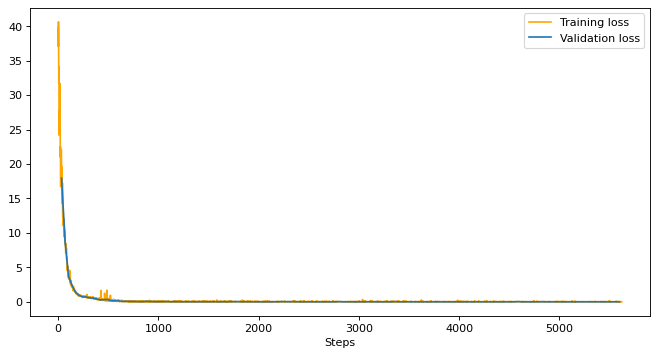

In [54]:
# visualizing the training and validation losses

fig = plt.figure(figsize=(10, 5), dpi=80)
plt.plot(train_loss_, color='orange', label='Training loss')

val_loss_df = copy.deepcopy(val_loss_)
val_loss_df.index = (val_loss_.index+1)*val_freq
plt.plot(val_loss_df, label='Validation loss')

plt.legend(loc="upper right")
plt.xlabel('Steps')

fig.savefig('/content/drive/MyDrive/lang-id/Loss/Loss_Plot.png', dpi=fig.dpi)

#TESTING

In [46]:
# function to test the model on 'max_iter' examples

def test_model(test_df, tokenizer, wrong_prediction, max_iter):

  max_test_iters = max_iter
  correct_predictions = 0

  for _ in range(max_test_iters):
    num = random.randint(0,len(test_df['input_text'])-1)
    test = test_df.iloc[num]

    input_ids = encode_str(text = test['input_text'], tokenizer = tokenizer, seq_len = 40)
    input_ids = input_ids.unsqueeze(0).cuda()

    #print('Truncated input text:', tokenizer.convert_tokens_to_string(
    #  tokenizer.convert_ids_to_tokens(input_ids[0])))

    output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
    # print(output_tokens)
    for token_set in output_tokens:
      prediction = tokenizer.decode(token_set,skip_special_tokens=True)
      if prediction == test['target_text']:
        correct_predictions += 1
      else:
        wrong_prediction.append([test['input_text'], test['target_text'], prediction])

  return correct_predictions/max_test_iters, wrong_prediction

In [47]:
# test the model on multiple batches to find average test accuracy.
# wrong predictions are saved to 'wrong_predictions.csv' file for further analysis.

Test_acc_values = []
wrong_pred = []
test_n_batches = 200
print('Model testing on test dataset: \n')
for _ in tqdm_notebook_(range(test_n_batches)):
  acc, wrong_pred = test_model(test_df, tokenizer, wrong_pred, max_iter=50)
  Test_acc_values.append(acc)


print('Avg. Test Accuracy: {:.4f}'.format(np.mean(Test_acc_values)))
wrong_pred_df = pd.DataFrame (wrong_pred, columns = ['Input_text', 'True_target', 'Predicted'])
wrong_pred_df.to_csv("/content/drive/MyDrive/lang-id/wrong_predictions.csv")


Model testing on test dataset: 



  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Avg. Test Accuracy: 0.9965


In [48]:
acc

1.0